<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Treatment Featurization Examples 

Many EconML estimators model treatment effects as linear with respect to the treatment. However, there are times when one may want to impose a particular form of non-linearity in the treatment effect. For example, one may believe that the outcome is linear with respect to treatment squared, or more generally, linear with respect to some featurization of the treatment. We enable users to pass such a featurization via the `treatment_featurizer` argument. This notebook walks through some examples where treatment featurization may be useful. 

Additional context and problem setup can be found in the docs at [this link](https://www.pywhy.org/EconML/spec/api.html#linear-in-treatment-cate-estimators).

The EconmL SDK supports treatment featurization for many estimators, including:

* Estimators given unconfoundedness
    * LinearDML
    * SparseLinearDML
    * KernelDML
    * CausalForestDML
    * DMLOrthoForest
    * NonParamDML
    * DML
    
* Estimators in an IV setting
    * OrthoIV
    * DMLIV
    * NonParamDMLIV
    * DRIV
    * LinearDRIV
    * SparseLinearDRIV
    * ForestDRIV
    

**Notebook contents:**
1. Treatment Featurization under Unconfoundedness
2. Treatment Featurization for IV methods 

# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EconML imports
from econml.dml import LinearDML
from econml.iv.dml import OrthoIV

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures # featurizer class
from sklearn.ensemble import RandomForestRegressor

# Basic examples 

## Treatment Featurization under Unconfoundedness 

### Simulate data 

We generate data where the outcome depends on the square of the treatment.

In [2]:
n = 2000
d_w = 5
W = np.random.normal(size = (n, d_w), scale = 5)
T = np.random.uniform(low = 0, high = 10, size = (n, 1)) + 0.5*W[:, [0]]
epsilon = np.random.normal(size = (n, 1))*20
Y = 0.5*T**2 + W[:, [1]] + epsilon

test_T = np.arange(0, 10, step = 0.1).reshape(-1, 1)

featurizer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

### Run estimation 

Here we run two estimators, one with treatment featurization and one without treatment featurization for comparison

In [3]:
est = LinearDML(treatment_featurizer = featurizer)
est.fit(Y=Y, T=T, W=W)

bad_est = LinearDML()
bad_est.fit(Y=Y, T=T, W=W)

est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,0.061,0.289,0.21,0.834,-0.506,0.628
cate_intercept|T0^2,0.507,0.024,21.467,0.0,0.461,0.554


### Plot effects 

Text(0.5, 1.0, 'Treatment Effect vs Treatment value')

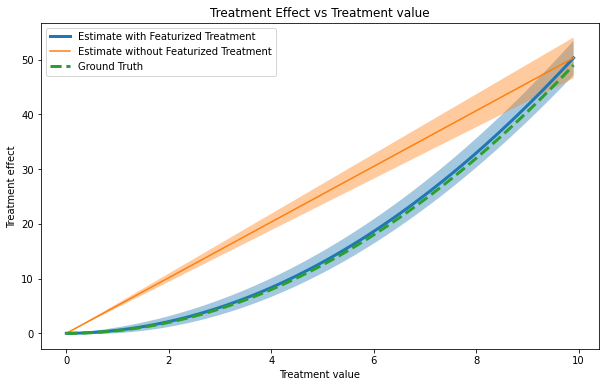

In [4]:
plt.figure(figsize=(10, 6))

# Plot point estimates
plt.plot(
    test_T,
    est.effect(T0 = 0, T1=test_T),
    label = 'Estimate with Featurized Treatment',
    linewidth=3
)

plt.plot(
    test_T,
    bad_est.effect(T0 = 0, T1=test_T),
    label = 'Estimate without Featurized Treatment'
)

plt.plot(
    test_T,
    0.5*test_T**2,
    linestyle='--',
    linewidth=3,
    label='Ground Truth',
)

# Plot confidence intervals
lb, ub = est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4,
)

lb, ub = bad_est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4
)

plt.legend()
plt.xlabel('Treatment value')
plt.ylabel('Treatment effect')
plt.title('Treatment Effect vs Treatment value')

## Treatment Featurization for IV methods 

### Simulate data 

In [5]:
n = 2000
d_w = 5
W = np.random.normal(size = (n, d_w), scale = 5)
unobserved_confounder = np.random.normal(size = (n, 1)) * 5
Z = np.random.normal(loc = 3, scale = 5, size = (n, 1))
T = np.random.uniform(low = 0, high = 10, size = (n, 1)) + 0.5*W[:, [0]] + Z + unobserved_confounder
epsilon = np.random.normal(size = (n, 1)) * 50
Y = 0.5*T**2 + W[:, [1]] + unobserved_confounder + epsilon

test_T = np.arange(0, 10, step = 0.1).reshape(-1, 1)

featurizer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

### Run estimation 

Here we run two estimators, one with treatment featurization and one without treatment featurization for comparison.

Note that OrthoIV requires that the dimension of the featurized treatment be less than or equal to the dimension of the instrument. So in the case where we have a featurized treatment that has higher dimension than our instrument, we can either featurize the instrument ourselves before passing it to the estimator or we can set `projection=True`, which will  fit efficient instruments, along with passing a flexible `model_t_xwz`. In principle we recommend the latter approach.

In [6]:
est = OrthoIV(
    model_t_xwz=RandomForestRegressor(),
    projection=True,
    treatment_featurizer = featurizer
)
est.fit(Y=Y, T=T, W=W, Z=Z)

bad_est = OrthoIV()
bad_est.fit(Y=Y, T=T, W=W, Z=Z)

est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,-0.731,0.539,-1.356,0.175,-1.787,0.326
cate_intercept|T0^2,0.537,0.031,17.467,0.0,0.477,0.598


Text(0.5, 1.0, 'Treatment Effect vs Treatment value')

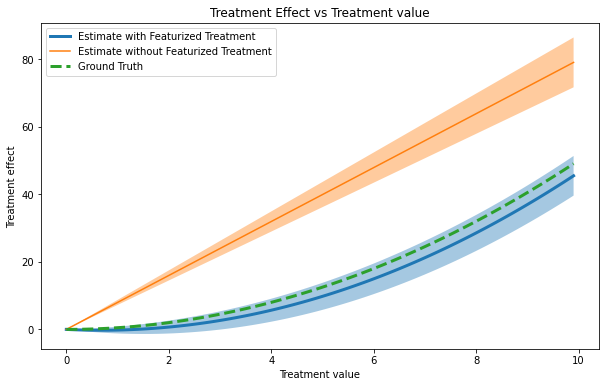

In [7]:
plt.figure(figsize=(10, 6))

# Plot point estimates
plt.plot(
    test_T,
    est.effect(T0 = 0, T1=test_T),
    label = 'Estimate with Featurized Treatment',
    linewidth=3
)

plt.plot(
    test_T,
    bad_est.effect(T0 = 0, T1=test_T),
    label = 'Estimate without Featurized Treatment'
)

plt.plot(
    test_T,
    0.5*test_T**2,
    linestyle='--',
    linewidth=3,
    label='Ground Truth',
)

# Plot confidence intervals
lb, ub = est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4,
)

lb, ub = bad_est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4
)

plt.legend()
plt.xlabel('Treatment value')
plt.ylabel('Treatment effect')
plt.title('Treatment Effect vs Treatment value')

## Applied example

Suppose you are a healthcare researcher interested in optimizing the dosage of a particular medicine, using observational data collected that measured dosage and wellbeing for patients of various attributes. 

You believe that your treatment affects patient outcome in a quadratic manner. You also believe that different customers will respond differently to your treatment. 

You can frame your data as follows: Let X be a patient characteristic that affects how they respond to changes in treatment. Let T be the dosage of your treatment. Let Y be the patient's wellbeing. Let W be other confounding variables that affect the treatment and outcome simultaneously.

### Data simulation 

We define a synthetic dataset as follows:

Note that while the outcome still varies linearly with featurized treatment, we use a non linear operation on X to define effect heterogeneity. In other words, if X>0.5, then the outcome depends on 2\*T - T^2, while if X<0.5, the outcome depends on 4\*(2*T - T^2)

In [8]:
n = 10000
d_w = 5
d_x = 1
W = np.random.normal(size = (n, d_w), scale = 5)
X = np.random.normal(size = (n, d_x), scale = 5)
T = np.random.uniform(low = 0, high = 10, size = (n, 1)) + 0.5*W[:, [0]] + 0.5*X[:, [0]]
epsilon = np.random.normal(size = (n, 1))*20

Y = np.where(X[:, [0]]>0.5, 1, 4) * (2*T - T**2) + X[:, [0]]+ W[:, [1]] + epsilon


featurizer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

Since we believe effect heterogeneity is nonlinear, we use CausalForestDML.

In [9]:
from econml.dml import CausalForestDML

In [10]:
# est = LinearDML(model_y=RandomForestRegressor(min_samples_leaf=20, random_state=123),
est = CausalForestDML(model_y=RandomForestRegressor(min_samples_leaf=20, random_state=123),
                model_t=RandomForestRegressor(min_samples_leaf=20, random_state=123),
                treatment_featurizer = featurizer,
                cv=5,
                random_state=123)
est.fit(Y=Y.flatten(), T=T, X=X, W=W)

Observe treatment effects for different x values as treatment varies.

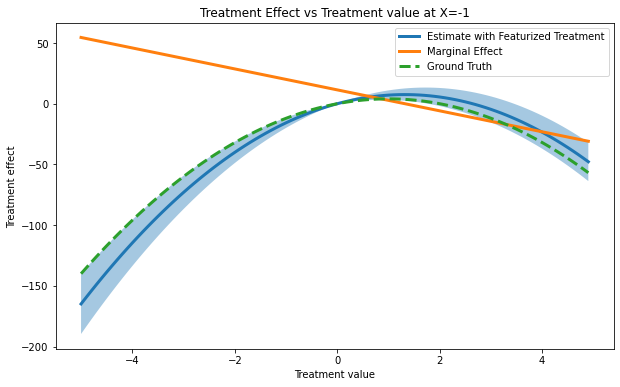

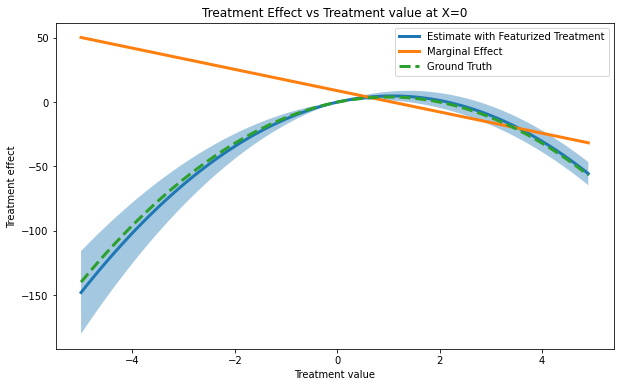

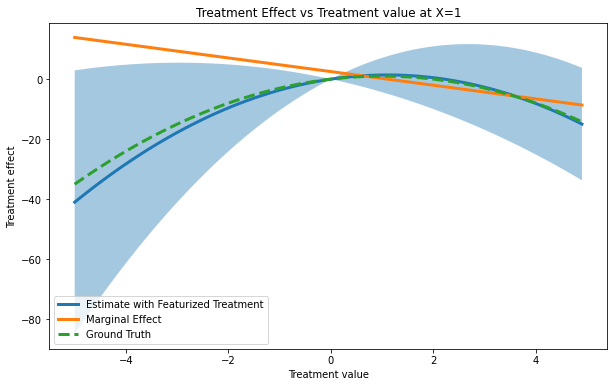

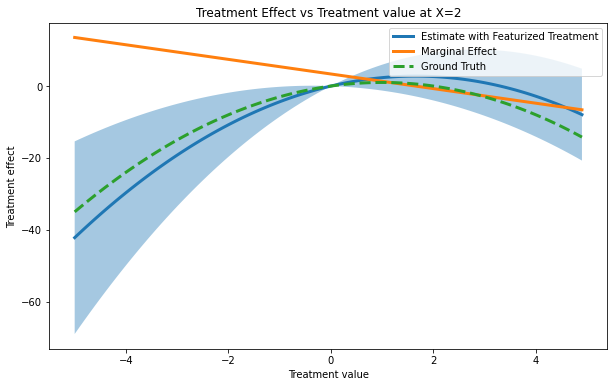

In [11]:
test_T = np.arange(-5, 5, step = 0.1).reshape(-1, 1)

x_vals= [-1, 0, 1, 2]

for x_val in x_vals:
    plt.figure(figsize=(10, 6))

    xtest = np.ones(test_T.shape) * x_val
    # Plot point estimates
    plt.plot(
        test_T,
        est.effect(xtest, T0 = 0, T1=test_T),
        label = 'Estimate with Featurized Treatment',
        linewidth=3
    )

    plt.plot(
        test_T,
        est.marginal_effect(test_T, xtest),
        label = 'Marginal Effect',
        linewidth=3
    )

    plt.plot(
        test_T,
        np.where(xtest>0.5, 1, 4) * (2*test_T - test_T**2),
        linestyle='--',
        linewidth=3,
        label='Ground Truth',
    )

    # Plot confidence intervals
    lb, ub = est.effect_interval(xtest, T0 = 0, T1=test_T)

    plt.fill_between(
        test_T.squeeze(),
        lb.squeeze(),
        ub.squeeze(),
        alpha = 0.4,
    )


    plt.legend()
    plt.xlabel('Treatment value')
    plt.ylabel('Treatment effect')
    plt.title(f'Treatment Effect vs Treatment value at X={x_val}')

We gather the marginal effect for existing samples and prescribe interventions (i.e. changes in treatment dosage.)

In [12]:
ns = 40
eff = est.marginal_effect(T[:ns], X[:ns])
lb, ub = est.marginal_effect_inference(T[:ns], X[:ns]).conf_int(alpha=.01)
true = (.5 + X[:ns, [0]]) * (np.ones((ns,1)) - 2 * T[:ns])
true = np.where(X[:ns, [0]]>0.5, 1, 4) * (np.ones((ns,1)) - 2 * T[:ns])
df = (
    pd.DataFrame({'X': X[:ns, 0], 'marginal effect': eff[:, 0], 'lb': lb[:, 0], 'ub': ub[:, 0], 'true': true[:, 0]})
    .assign(
        presciption = lambda df: df['marginal effect'].gt(0).map({True: 'Increase treatment',
                                                                  False: 'Decrease treatment'})
    )
)

df

,X,marginal effect,lb,ub,true,presciption
0,-1.964775,-30.157065,-32.856818,-27.457311,-31.657195,Decrease treatment
1,-4.976109,38.821192,34.239351,43.403033,35.247105,Increase treatment
2,-1.222882,-15.234570,-18.565181,-11.903959,-20.269921,Decrease treatment
3,3.991654,-16.428203,-19.629034,-13.227373,-15.480751,Decrease treatment
4,2.296386,9.529916,6.753388,12.306444,5.865886,Increase treatment
5,3.957914,2.373906,-3.624517,8.372328,-1.632855,Increase treatment
6,-1.128893,-4.281499,-7.800553,-0.762444,-6.282670,Decrease treatment
7,0.878929,-7.576779,-10.937542,-4.216015,-8.584140,Decrease treatment
8,4.884313,-26.683832,-29.480043,-23.887622,-26.062601,Decrease treatment
9,5.683501,-28.384068,-35.917722,-20.850415,-27.269113,Decrease treatment


Marginal effect vs ground truth

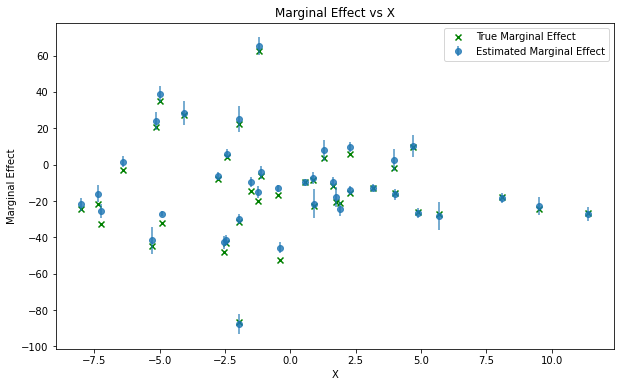

In [13]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    df['X'], df['marginal effect'],
    yerr=[df['marginal effect'] - df['lb'], df['ub'] - df['marginal effect']],
    fmt='o', alpha = 0.8, label = 'Estimated Marginal Effect')
plt.scatter(df['X'], df['true'], marker='x', color='green', label = 'True Marginal Effect')

plt.xlabel('X')
plt.ylabel('Marginal Effect')
plt.title('Marginal Effect vs X')

plt.legend()
plt.show()